In [1]:
import sys
sys.path.append('../../../')
sys.path.append('/home/sheida.rahnamai/GIT/HDN/')
import torch
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread
import glob
import matplotlib.patches as patches
import hdbscan as hd
from hdbscan import prediction
from sklearn.cluster import HDBSCAN
from collections import Counter
from openTSNE import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
# %reload lib.plotting 
from lib import plotting as p
from lib import dataprep as dp
import random
import umap
from tqdm import tqdm
from lib.evaluation import FeatureExtractor
# from lib.dataloader import CustomTestDataset
from lib.dataloader import CustomDataset
import tifffile as tiff
from sklearn.utils import shuffle
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import os
from boilerplate import boilerplate
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors



/localscratch/emseg_ls/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
reload(p)
from lib import plotting as p

## Loading the model

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

patch_size = 64
sample_size = 200
centre_size = 4
n_channel = 32
hierarchy_level = 3
pad_size = (patch_size - centre_size) // 2
model_dir = "/group/jug/Sheida/HVAE/cl_w_bg_v0/"
# model_dir = "/group/jug/Sheida/HVAE/Hyperparameter_search/legendary-violet-547-2nd-cl1e-3_kl1/"
model = torch.load(model_dir+"model/HVAE_best_vae.net")

### Loading train data
### Sample from different classes
### Loading test data

In [4]:
# train data

data_dir = "/localscratch/data/"
Three_train_images = ['high_c1', 'high_c2', 'high_c3']

# Load source images
train_img_paths = [os.path.join(data_dir, img, f"{img}_source.tif") for img in Three_train_images]
images = {img: tiff.imread(path) for img, path in zip(Three_train_images, train_img_paths)}

# Print loaded train images paths
print("Train images loaded from paths:")
for img, path in zip(Three_train_images, train_img_paths):
   print(path)

labels = {}
# Load ground truth images
for img in Three_train_images:
   gt_path = os.path.join(data_dir, img, f"{img}_gt.tif")
   labels[img] = tiff.imread(gt_path)

# Initialize dictionaries for the split data
train_images = {}
val_images = {}
train_labels = {}
val_labels = {}

keys = ['high_c1', 'high_c2', 'high_c3']

for key in tqdm(keys, desc='Splitting data'):
   filtered_image, filtered_label = boilerplate._filter_slices(images[key], labels[key])
   train_image, val_image, train_label, val_label = boilerplate._split_slices(
      filtered_image, filtered_label
   )
   train_images[key] = train_image
   val_images[key] = val_image
   train_labels[key] = train_label
   val_labels[key] = val_label

# compute mean and std of the data
all_elements = np.concatenate([train_images[key].flatten() for key in keys])
data_mean = np.mean(all_elements)
data_std = np.std(all_elements)

# normalizing the data
for key in tqdm(keys, 'Normalizing data'):
   train_images[key] = (train_images[key] - data_mean) / data_std
   val_images[key] = (val_images[key] - data_mean) / data_std

train_set = CustomDataset(train_images, train_labels)
val_set = CustomDataset(val_images, val_labels)

One_test_image = ['high_c4']

# Load test image
test_img_path = os.path.join(data_dir, One_test_image[0], f"{One_test_image[0]}_source.tif")
test_image = tiff.imread(test_img_path)

# Print loaded test images paths
print("Test image loaded from path:")
print(test_img_path)

# Load test ground truth images
test_gt_path = os.path.join(data_dir, One_test_image[0], f"{One_test_image[0]}_gt.tif")
test_ground_truth_image = tiff.imread(test_gt_path)

bg_indices = random.sample(train_set.patches_by_label[0],sample_size)
nucleus_indices = random.sample(train_set.patches_by_label[1],sample_size)
granule_indices = random.sample(train_set.patches_by_label[2],sample_size)
mito_indices = random.sample(train_set.patches_by_label[3],sample_size)

bg_samples, bg_cls, bg_lbl = train_set[bg_indices]
nucleus_samples, nucleus_cls, nucleus_lbl = train_set[nucleus_indices]
granule_samples, granule_cls, granule_lbl = train_set[granule_indices]
mito_samples, mito_cls, mito_lbl = train_set[mito_indices]

bg_samples = bg_samples.squeeze(1)
bg_lbl = bg_lbl.squeeze(1)
nucleus_samples = nucleus_samples.squeeze(1)
nucleus_lbl = nucleus_lbl.squeeze(1)
granule_samples = granule_samples.squeeze(1)
granule_lbl = granule_lbl.squeeze(1)
mito_samples = mito_samples.squeeze(1)
mito_lbl = mito_lbl.squeeze(1)

#test data

test_images = (test_image-data_mean)/data_std

test_slice = test_images[626]
test_slice_lbl = test_ground_truth_image[626]

Train images loaded from paths:
/localscratch/data/high_c1/high_c1_source.tif
/localscratch/data/high_c2/high_c2_source.tif
/localscratch/data/high_c3/high_c3_source.tif


Normalizing data: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]
Extracting patches from high_c1: 966it [00:03, 315.05it/s]
Extracting patches from high_c2: 891it [00:02, 345.46it/s]
Extracting patches from high_c3: 909it [00:02, 336.09it/s]
Extracting patches from high_c1: 108it [00:00, 367.01it/s]
Extracting patches from high_c2: 99it [00:00, 364.65it/s]
Extracting patches from high_c3: 101it [00:00, 384.44it/s]


Test image loaded from path:
/localscratch/data/high_c4/high_c4_source.tif


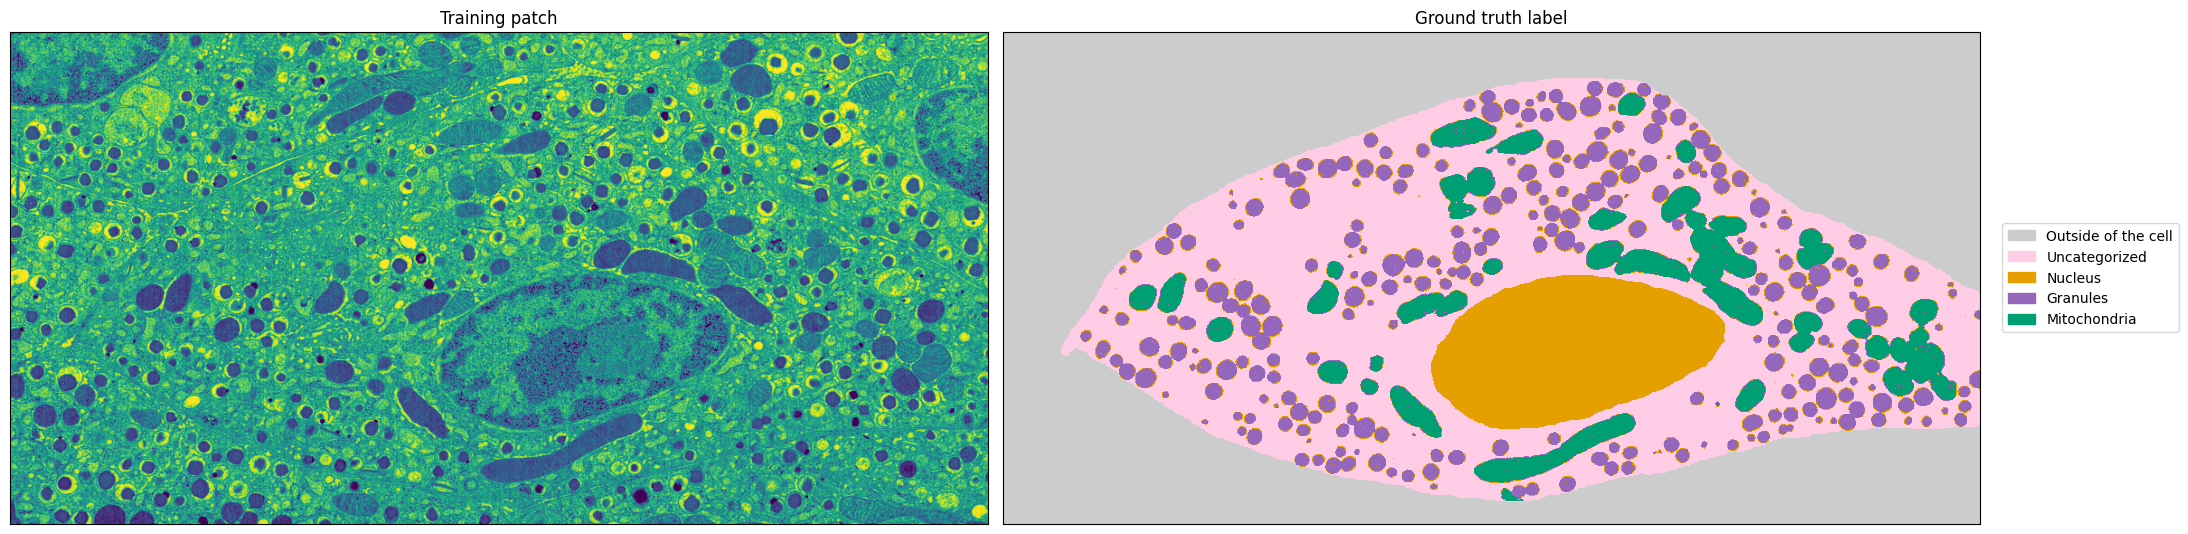

In [5]:
p.plot_w_b((test_slice, 'Training patch', False),\
        (test_slice_lbl, 'Ground truth label', False),\
        plot_types=['imshow', 'imshow_l'],\
        box_size = 10
        )

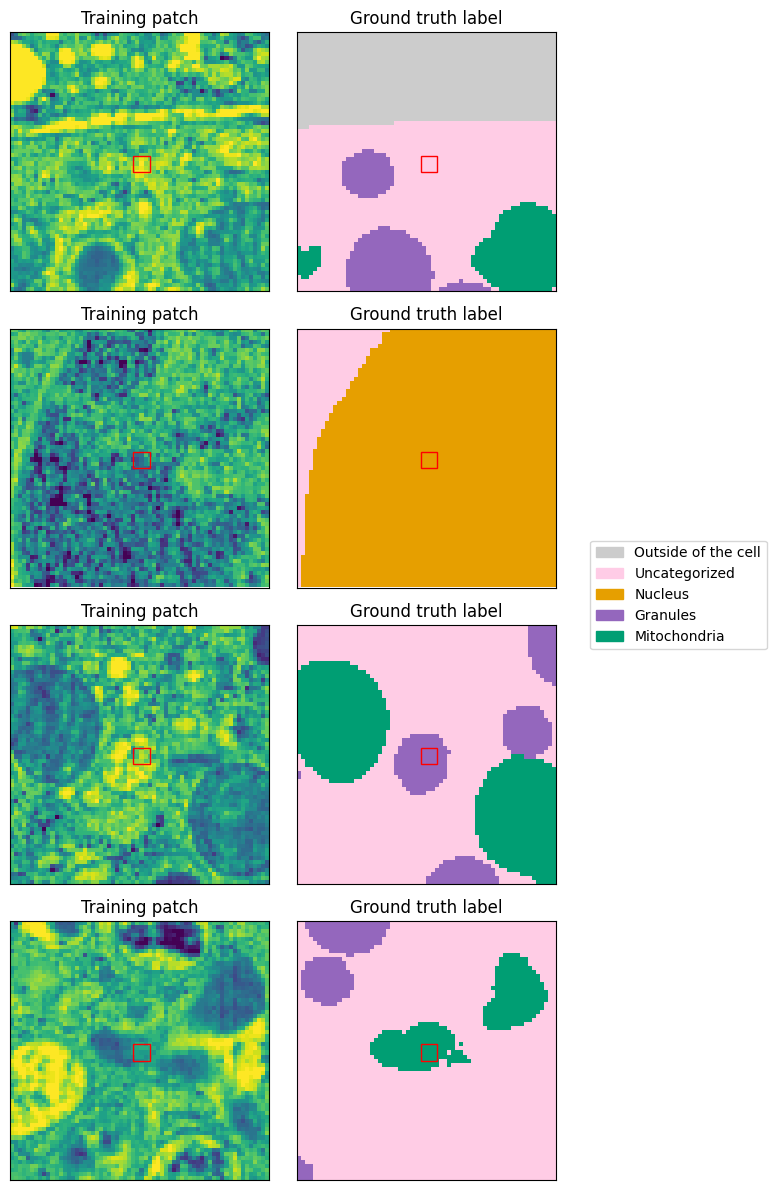

In [6]:
i, j, k, l = np.random.randint(0, sample_size, 4)
p.plot_w_b((bg_samples[i], 'Training patch', (pad_size, pad_size, centre_size)),\
        (bg_lbl[i], 'Ground truth label', (pad_size, pad_size, centre_size)),\
        (nucleus_samples[j], 'Training patch', (pad_size, pad_size, centre_size)),\
        (nucleus_lbl[j], 'Ground truth label', (pad_size, pad_size, centre_size)),\
        (granule_samples[k], 'Training patch', (pad_size, pad_size, centre_size)),\
        (granule_lbl[k], 'Ground truth label', (pad_size, pad_size, centre_size)),\
        (mito_samples[l], 'Training patch', (pad_size, pad_size, centre_size)),\
        (mito_lbl[l], 'Ground truth label', (pad_size, pad_size, centre_size)),\
        plot_types=['imshow', 'imshow_l', 'imshow', 'imshow_l', 'imshow', 'imshow_l', 'imshow', 'imshow_l']
        )

## Extracting latent space from Encoder

In [7]:
bg_mu, nuc_mu, gra_mu, mito_mu = np.empty((0, 43008)), np.empty((0, 43008)), np.empty((0, 43008)), np.empty((0, 43008))
FE = FeatureExtractor(model, patch_size, centre_size)
for idx in range(sample_size):
    mu = FE.get_feature_maps(bg_samples[idx])
    bg_mu = np.vstack([bg_mu, mu])
    mu = FE.get_feature_maps(nucleus_samples[idx])
    nuc_mu = np.vstack([nuc_mu, mu])
    mu = FE.get_feature_maps(granule_samples[idx])
    gra_mu = np.vstack([gra_mu, mu])
    mu = FE.get_feature_maps(mito_samples[idx])
    mito_mu = np.vstack([mito_mu, mu])
train_mu = np.concatenate((bg_mu, nuc_mu, gra_mu, mito_mu), axis=0)
train_labels = np.array([0] * sample_size + [1] * sample_size + [2] * sample_size + [3] * sample_size)

In [8]:
def get_patch(image, labels, cls, patch_size):
    while True: 
        patch, label, y, x = dp.get_random_patch(image, labels, patch_size)
        centre = label[pad_size:pad_size+centre_size,pad_size:pad_size+centre_size]
        if cls in centre and np.unique(centre).size == 1:
                return patch, label, y, x


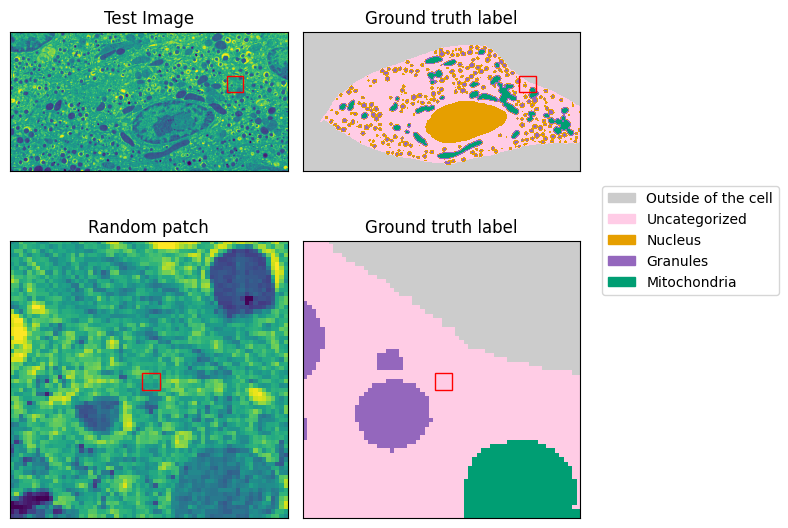

In [9]:
bg_patch, bg_label, y, x = get_patch(test_slice, test_slice_lbl, 0, patch_size)
test_mu_bg = FE.get_feature_maps(bg_patch)
test_mu_bg = np.expand_dims(test_mu_bg, axis=0)

p.plot_w_b( (test_slice, "Test Image", (y, x, patch_size)),\
        (test_slice_lbl, "Ground truth label", (y, x, patch_size)),\
        (bg_patch, "Random patch", (pad_size, pad_size, centre_size)),\
        (bg_label, "Ground truth label", (pad_size, pad_size, centre_size)),\
        plot_types=['imshow', 'imshow_l', 'imshow', 'imshow_l'],
        )

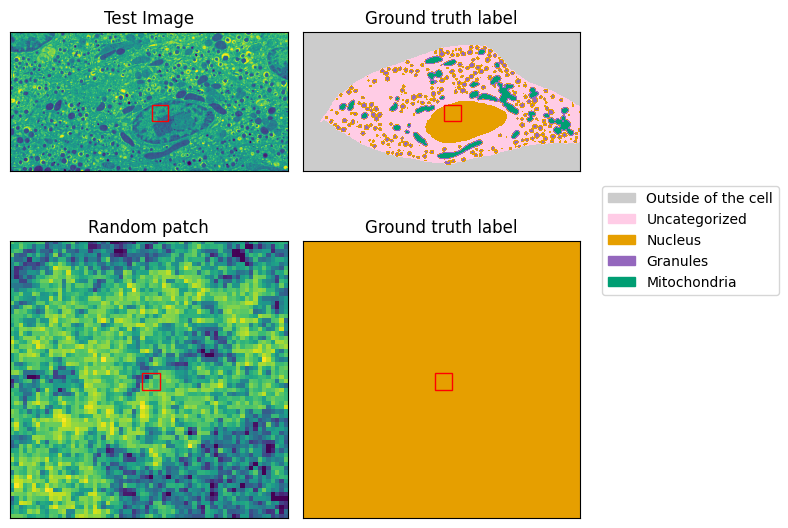

In [10]:
nuc_patch, nuc_label, y, x = get_patch(test_slice, test_slice_lbl, 1, patch_size)
test_mu_nuc = FE.get_feature_maps(nuc_patch)
test_mu_nuc = np.expand_dims(test_mu_nuc, axis=0)

p.plot_w_b( (test_slice, "Test Image", (y, x, patch_size)),\
        (test_slice_lbl, "Ground truth label", (y, x, patch_size)),\
        (nuc_patch, "Random patch", (pad_size, pad_size, centre_size)),\
        (nuc_label, "Ground truth label", (pad_size, pad_size, centre_size)),\
        plot_types=['imshow', 'imshow_l', 'imshow', 'imshow_l'],
        )

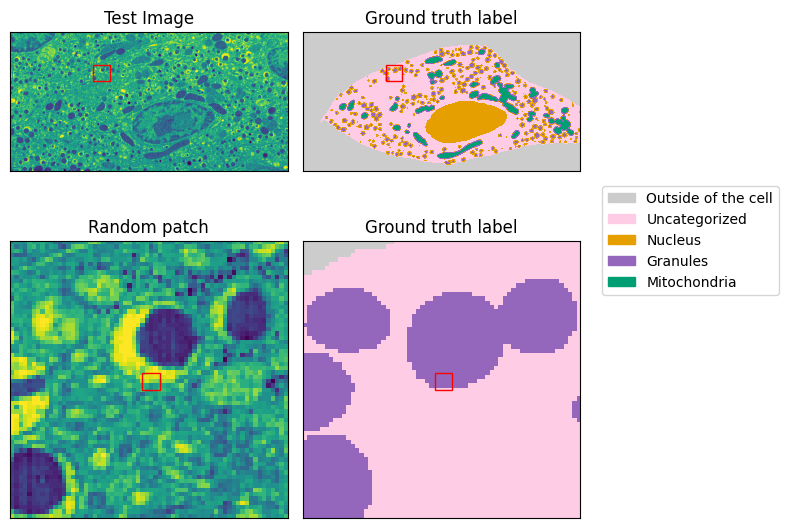

In [11]:
gra_patch, gra_label, y, x = get_patch(test_slice, test_slice_lbl, 2, patch_size)
test_mu_gra = FE.get_feature_maps(gra_patch)
test_mu_gra = np.expand_dims(test_mu_gra, axis=0)

p.plot_w_b( (test_slice, "Test Image", (y, x, patch_size)),\
        (test_slice_lbl, "Ground truth label", (y, x, patch_size)),\
        (gra_patch, "Random patch", (pad_size, pad_size, centre_size)),\
        (gra_label, "Ground truth label", (pad_size, pad_size, centre_size)),\
        plot_types=['imshow', 'imshow_l', 'imshow', 'imshow_l'],
        )

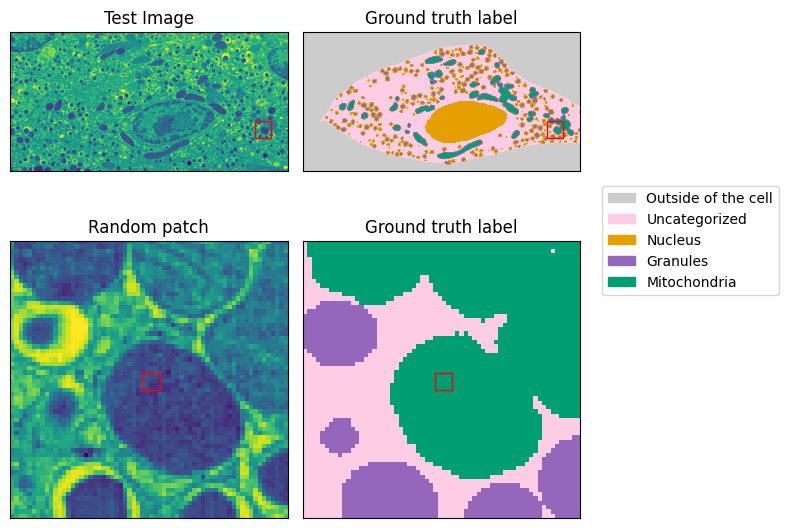

In [12]:
mito_patch, mito_label, y, x = get_patch(test_slice, test_slice_lbl, 3, patch_size)
test_mu_mito = FE.get_feature_maps(mito_patch)
test_mu_mito = np.expand_dims(test_mu_mito, axis=0)

p.plot_w_b( (test_slice, "Test Image", (y, x, patch_size)),\
        (test_slice_lbl, "Ground truth label", (y, x, patch_size)),\
        (mito_patch, "Random patch", (pad_size, pad_size, centre_size)),\
        (mito_label, "Ground truth label", (pad_size, pad_size, centre_size)),\
        plot_types=['imshow', 'imshow_l', 'imshow', 'imshow_l'],
        )

## t-SNE

In [13]:
tsne_3d = TSNE(
    n_components=3,
    random_state=42,
    learning_rate="auto",
    metric="euclidean",
    n_iter=10000,
).fit(train_mu)

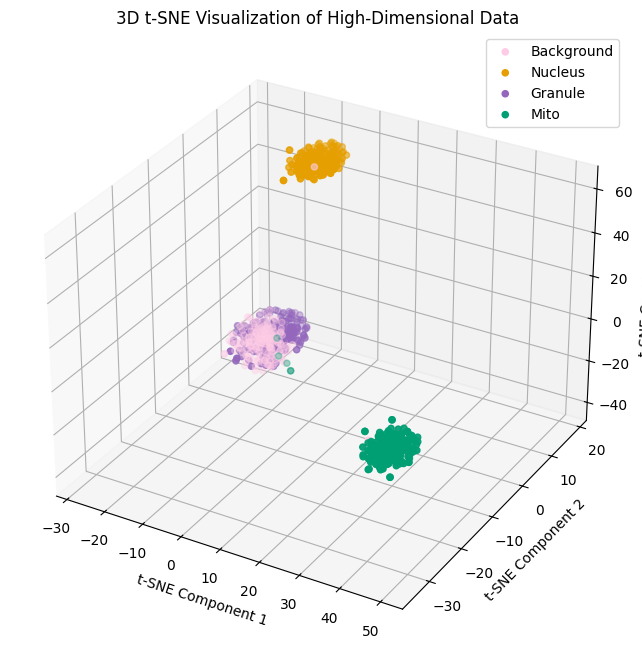

In [14]:
colors = [
        (0.8, 0.8, 0.8),               # white for label -1
        (1, 0.8, 0.9),          # pink for label 0
        (230/255, 159/255, 0),  # orange for label 1
        (0.5803921568627451, 0.403921568627451, 0.7411764705882353), # violet for label 2
        (0, 158/255, 115/255),  # bluish green for label 3
        
    ]

# Create the colormap
cmap = mcolors.ListedColormap(colors)
# Define the bounds and normalization
bounds = [-1, 0, 1, 2, 3, 4]    
norm = mcolors.BoundaryNorm(bounds, cmap.N)
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
label = ['Background', 'Nucleus', 'Granule', 'Mito']
# Plot the data points with true labels
for i in range(4):
    cluster_points = tsne_3d[train_labels == i]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=label[i], c=200*[i], cmap=cmap, norm=norm)

ax.set_title("3D t-SNE Visualization of High-Dimensional Data")
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")
ax.legend()
plt.show()


In [15]:
tsne = []
tsne = TSNE(
    n_components=2,
    random_state=42,
    learning_rate="auto",
    metric="cosine",
    n_iter=10000,
).fit(train_mu)
bg_tsne = tsne[:sample_size]
nuc_tsne = tsne[sample_size:2*sample_size]
gra_tsne = tsne[2*sample_size:3*sample_size]
mito_tsne = tsne[3*sample_size:]

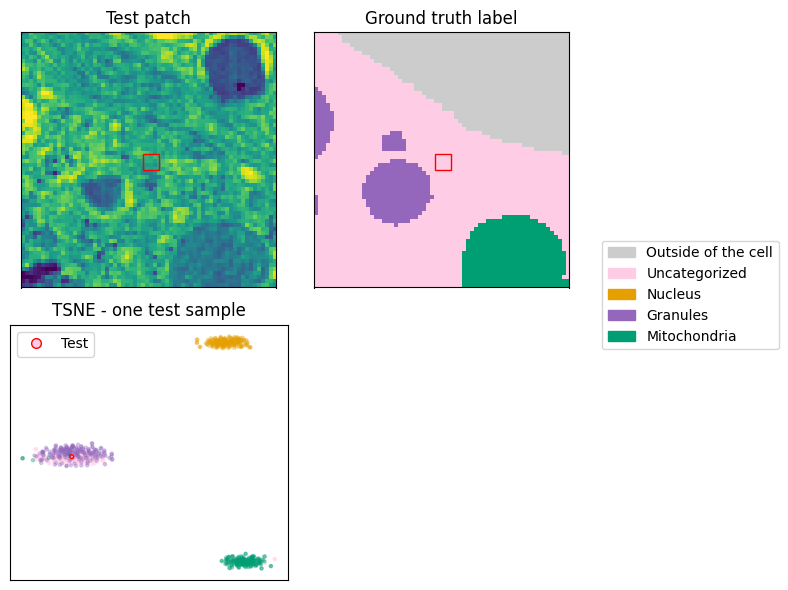

In [16]:
test_tsne = tsne.transform(test_mu_bg)
point_size = 5
p.plot_w_b( (bg_patch, "Test patch", (pad_size, pad_size, centre_size)),\
        (bg_label, "Ground truth label", (pad_size, pad_size, centre_size)),\
        ([bg_tsne, nuc_tsne, gra_tsne, mito_tsne, test_tsne], "TSNE - one test sample",\
                 [([0]*sample_size,point_size), ([1]*sample_size,point_size), ([2]*sample_size,point_size),\
                   ([3]*sample_size,point_size), ([0],point_size)]),\
        plot_types=['imshow', 'imshow_l', 'scatter'],
        )

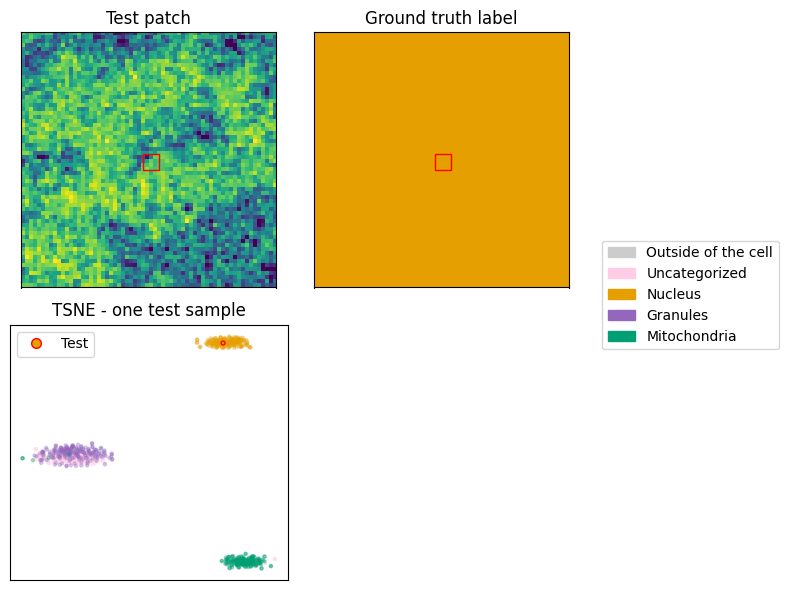

In [17]:
test_tsne = tsne.transform(test_mu_nuc)
point_size = 5
p.plot_w_b( (nuc_patch, "Test patch", (pad_size, pad_size, centre_size)),\
        (nuc_label, "Ground truth label", (pad_size, pad_size, centre_size)),\
        ([bg_tsne, nuc_tsne, gra_tsne, mito_tsne, test_tsne], "TSNE - one test sample",\
                 [([0]*sample_size,point_size), ([1]*sample_size,point_size), ([2]*sample_size,point_size),\
                   ([3]*sample_size,point_size), ([1],point_size)]),\
        plot_types=['imshow', 'imshow_l', 'scatter'],
        )

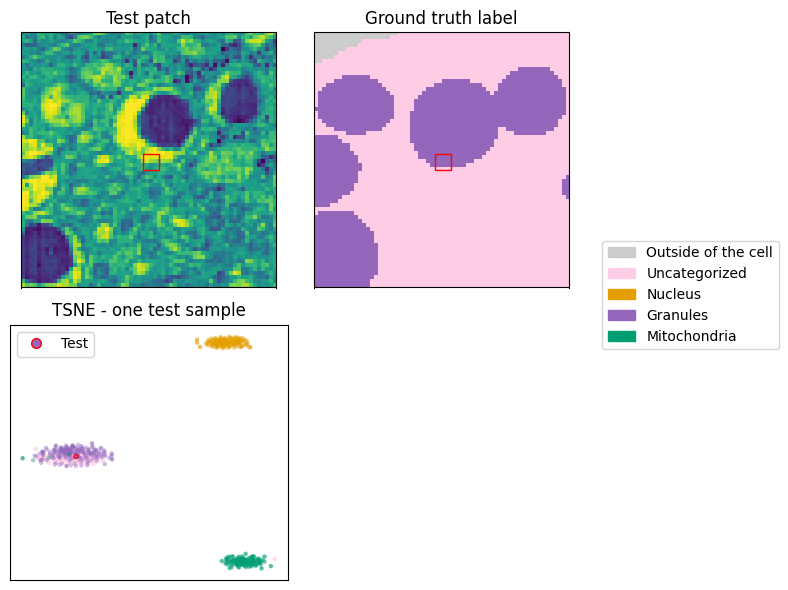

In [18]:
test_tsne = tsne.transform(test_mu_gra)
point_size = 5
p.plot_w_b( (gra_patch, "Test patch", (pad_size, pad_size, centre_size)),\
        (gra_label, "Ground truth label", (pad_size, pad_size, centre_size)),\
        ([bg_tsne, nuc_tsne, gra_tsne, mito_tsne, test_tsne], "TSNE - one test sample",\
                 [([0]*sample_size,point_size), ([1]*sample_size,point_size), ([2]*sample_size,point_size),\
                   ([3]*sample_size,point_size), ([2],point_size)]),\
        plot_types=['imshow', 'imshow_l', 'scatter'],
        )

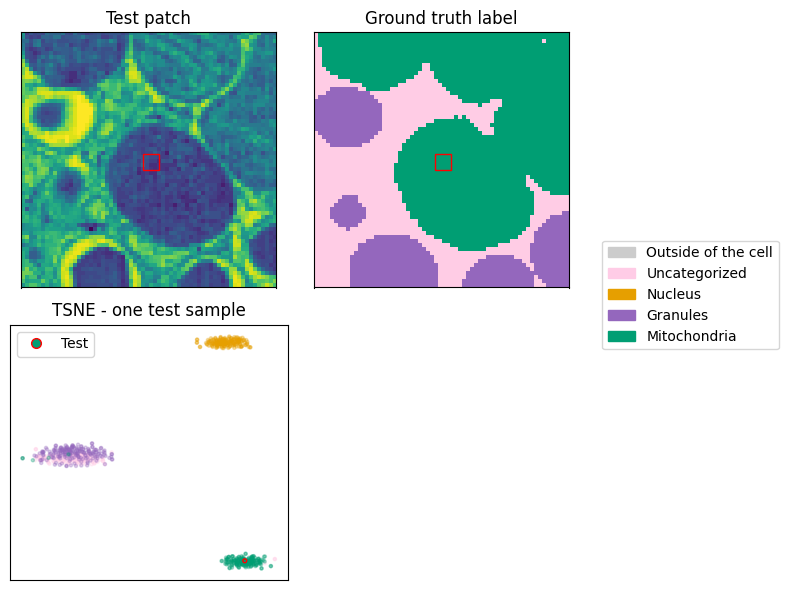

In [19]:
test_tsne = tsne.transform(test_mu_mito)
point_size = 5
p.plot_w_b( (mito_patch, "Test patch", (pad_size, pad_size, centre_size)),\
        (mito_label, "Ground truth label", (pad_size, pad_size, centre_size)),\
        ([bg_tsne, nuc_tsne, gra_tsne, mito_tsne, test_tsne], "TSNE - one test sample",\
                 [([0]*sample_size,point_size), ([1]*sample_size,point_size), ([2]*sample_size,point_size),\
                   ([3]*sample_size,point_size), ([3],point_size)]),\
        plot_types=['imshow', 'imshow_l', 'scatter'],
        )

## KMeans

In [20]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(tsne)
train_labels_kmean = kmeans.labels_

In [21]:
Counter(train_labels_kmean)

Counter({3: 265, 1: 201, 2: 201, 0: 133})

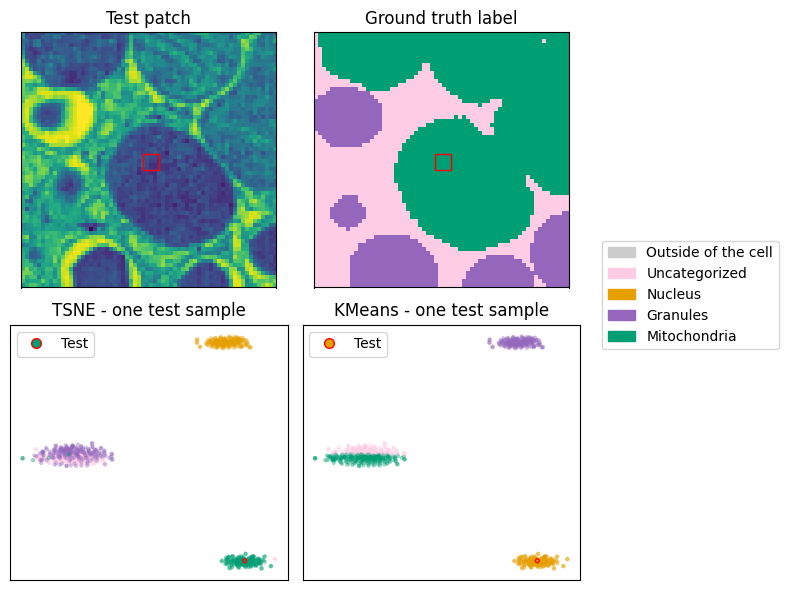

In [22]:
train_labels_kmean
test_kmeans = kmeans.predict(test_tsne)
point_size = 5
p.plot_w_b( (mito_patch, "Test patch", (pad_size, pad_size, centre_size)),\
        (mito_label, "Ground truth label", (pad_size, pad_size, centre_size)),\
        ([bg_tsne, nuc_tsne, gra_tsne, mito_tsne, test_tsne], "TSNE - one test sample",\
                 [([0]*sample_size,point_size), ([1]*sample_size,point_size), ([2]*sample_size,point_size),\
                   ([3]*sample_size,point_size), ([3],point_size)]),\
        ([bg_tsne, nuc_tsne, gra_tsne, mito_tsne, test_tsne], "KMeans - one test sample",\
                 [(train_labels_kmean[:sample_size],point_size), (train_labels_kmean[sample_size:2*sample_size],point_size),\
                  (train_labels_kmean[2*sample_size:3*sample_size],point_size),(train_labels_kmean[3*sample_size:],point_size), (test_kmeans,point_size)]),\
        plot_types=['imshow', 'imshow_l', 'scatter', 'scatter'],
        )

In [23]:
pca = PCA(n_components=200)
x_mu_reduced = pca.fit_transform(train_mu)
# new_point_reduced = pca.transform(feature_map.reshape(1, -1))

scaler = StandardScaler()
mus_normalized = scaler.fit_transform(x_mu_reduced)

gmm = GaussianMixture(n_components=4, covariance_type='tied', random_state=0)
gmm.fit(mus_normalized)
# new_mu_normalized = scaler.transform(new_point_reduced.reshape(1, -1))

# probs = gmm.predict_proba(new_mu_normalized)
# print(probs)

GaussianMixture(covariance_type='tied', n_components=4, random_state=0)

In [24]:
labels_gmm = gmm.predict(mus_normalized)

In [25]:
Counter(labels_gmm)

Counter({1: 451, 2: 168, 3: 156, 0: 25})

In [ ]:
# Evaluate Agglomerative clustering
agg_ari = adjusted_rand_score(true_labels, agg_labels)
agg_nmi = normalized_mutual_info_score(true_labels, agg_labels)

print("Agglomerative Clustering ARI:", agg_ari)
print("Agglomerative Clustering NMI:", agg_nmi)

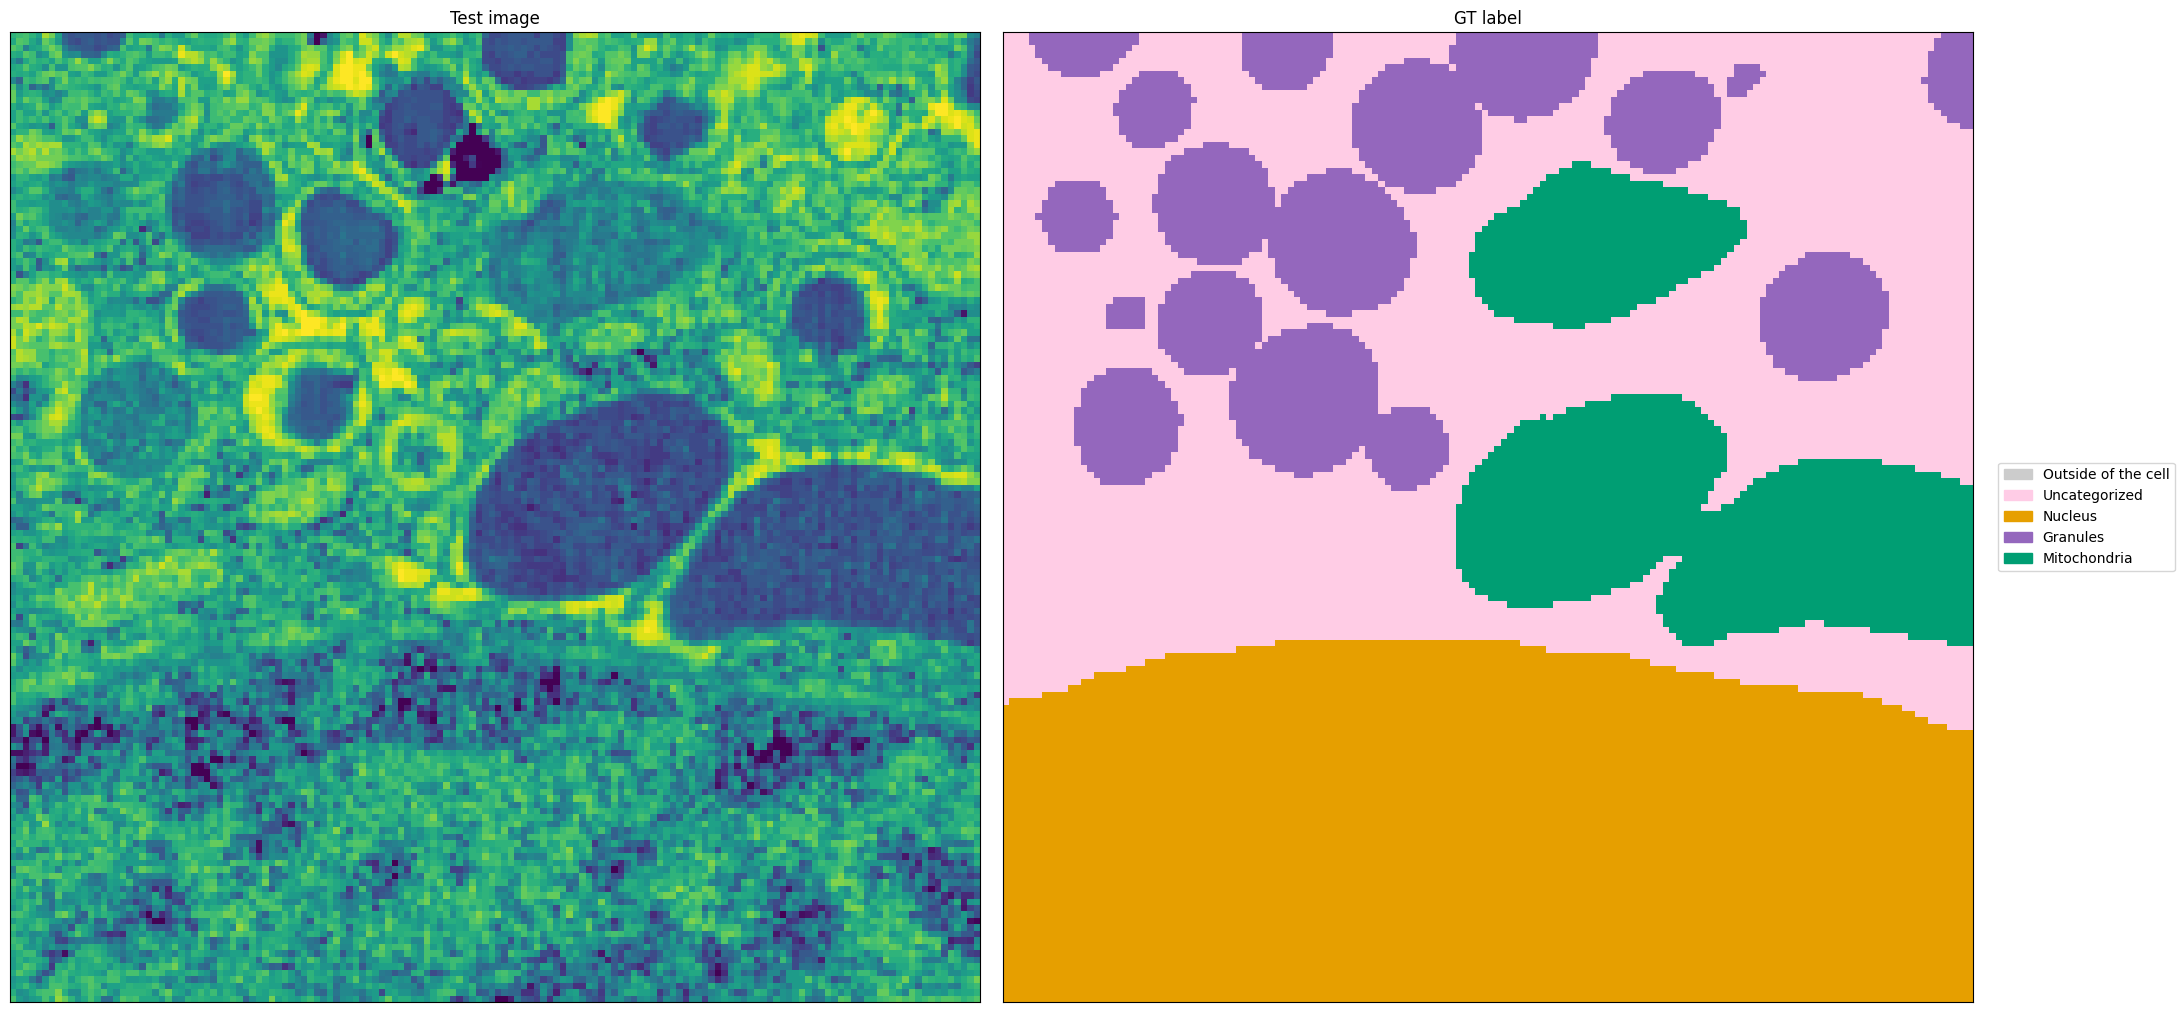

In [42]:
x1 = 575
x2 = 725
y1 = 175
y2 = 325
p.plot_w_b((test_slice[y1:y2, x1:x2], "Test image", False),\
            (test_slice_lbl[y1:y2, x1:x2], "GT label", False),\
            plot_types=['imshow', 'imshow_l'],
            box_size=10)

In [37]:
h, w = test_images[i][y1:y2, x1:x2].shape
new_h, new_w = h - patch_size + 1, w - patch_size + 1
feature_maps = np.zeros((new_h, new_w))
all_patches, all_labels = dp.get_all_patches(test_slice[y1:y2, x1:x2], test_slice_lbl[y1:y2, x1:x2], patch_size, stride=1)
idx = 0
for y in tqdm(range(new_h)):
    for x in range(new_w):
        mu = FE.get_feature_maps(all_patches[idx])
        feature_maps[y][x] = FE.get_closest(train_mu, mu)
        idx += 1

100%|██████████| 87/87 [14:26<00:00,  9.97s/it]


In [31]:
# result = np.where(test_slice_lbl[y1+pad_size:y2-pad_size-3, x1+pad_size:x2-pad_size-3] != 0, feature_maps, 0)

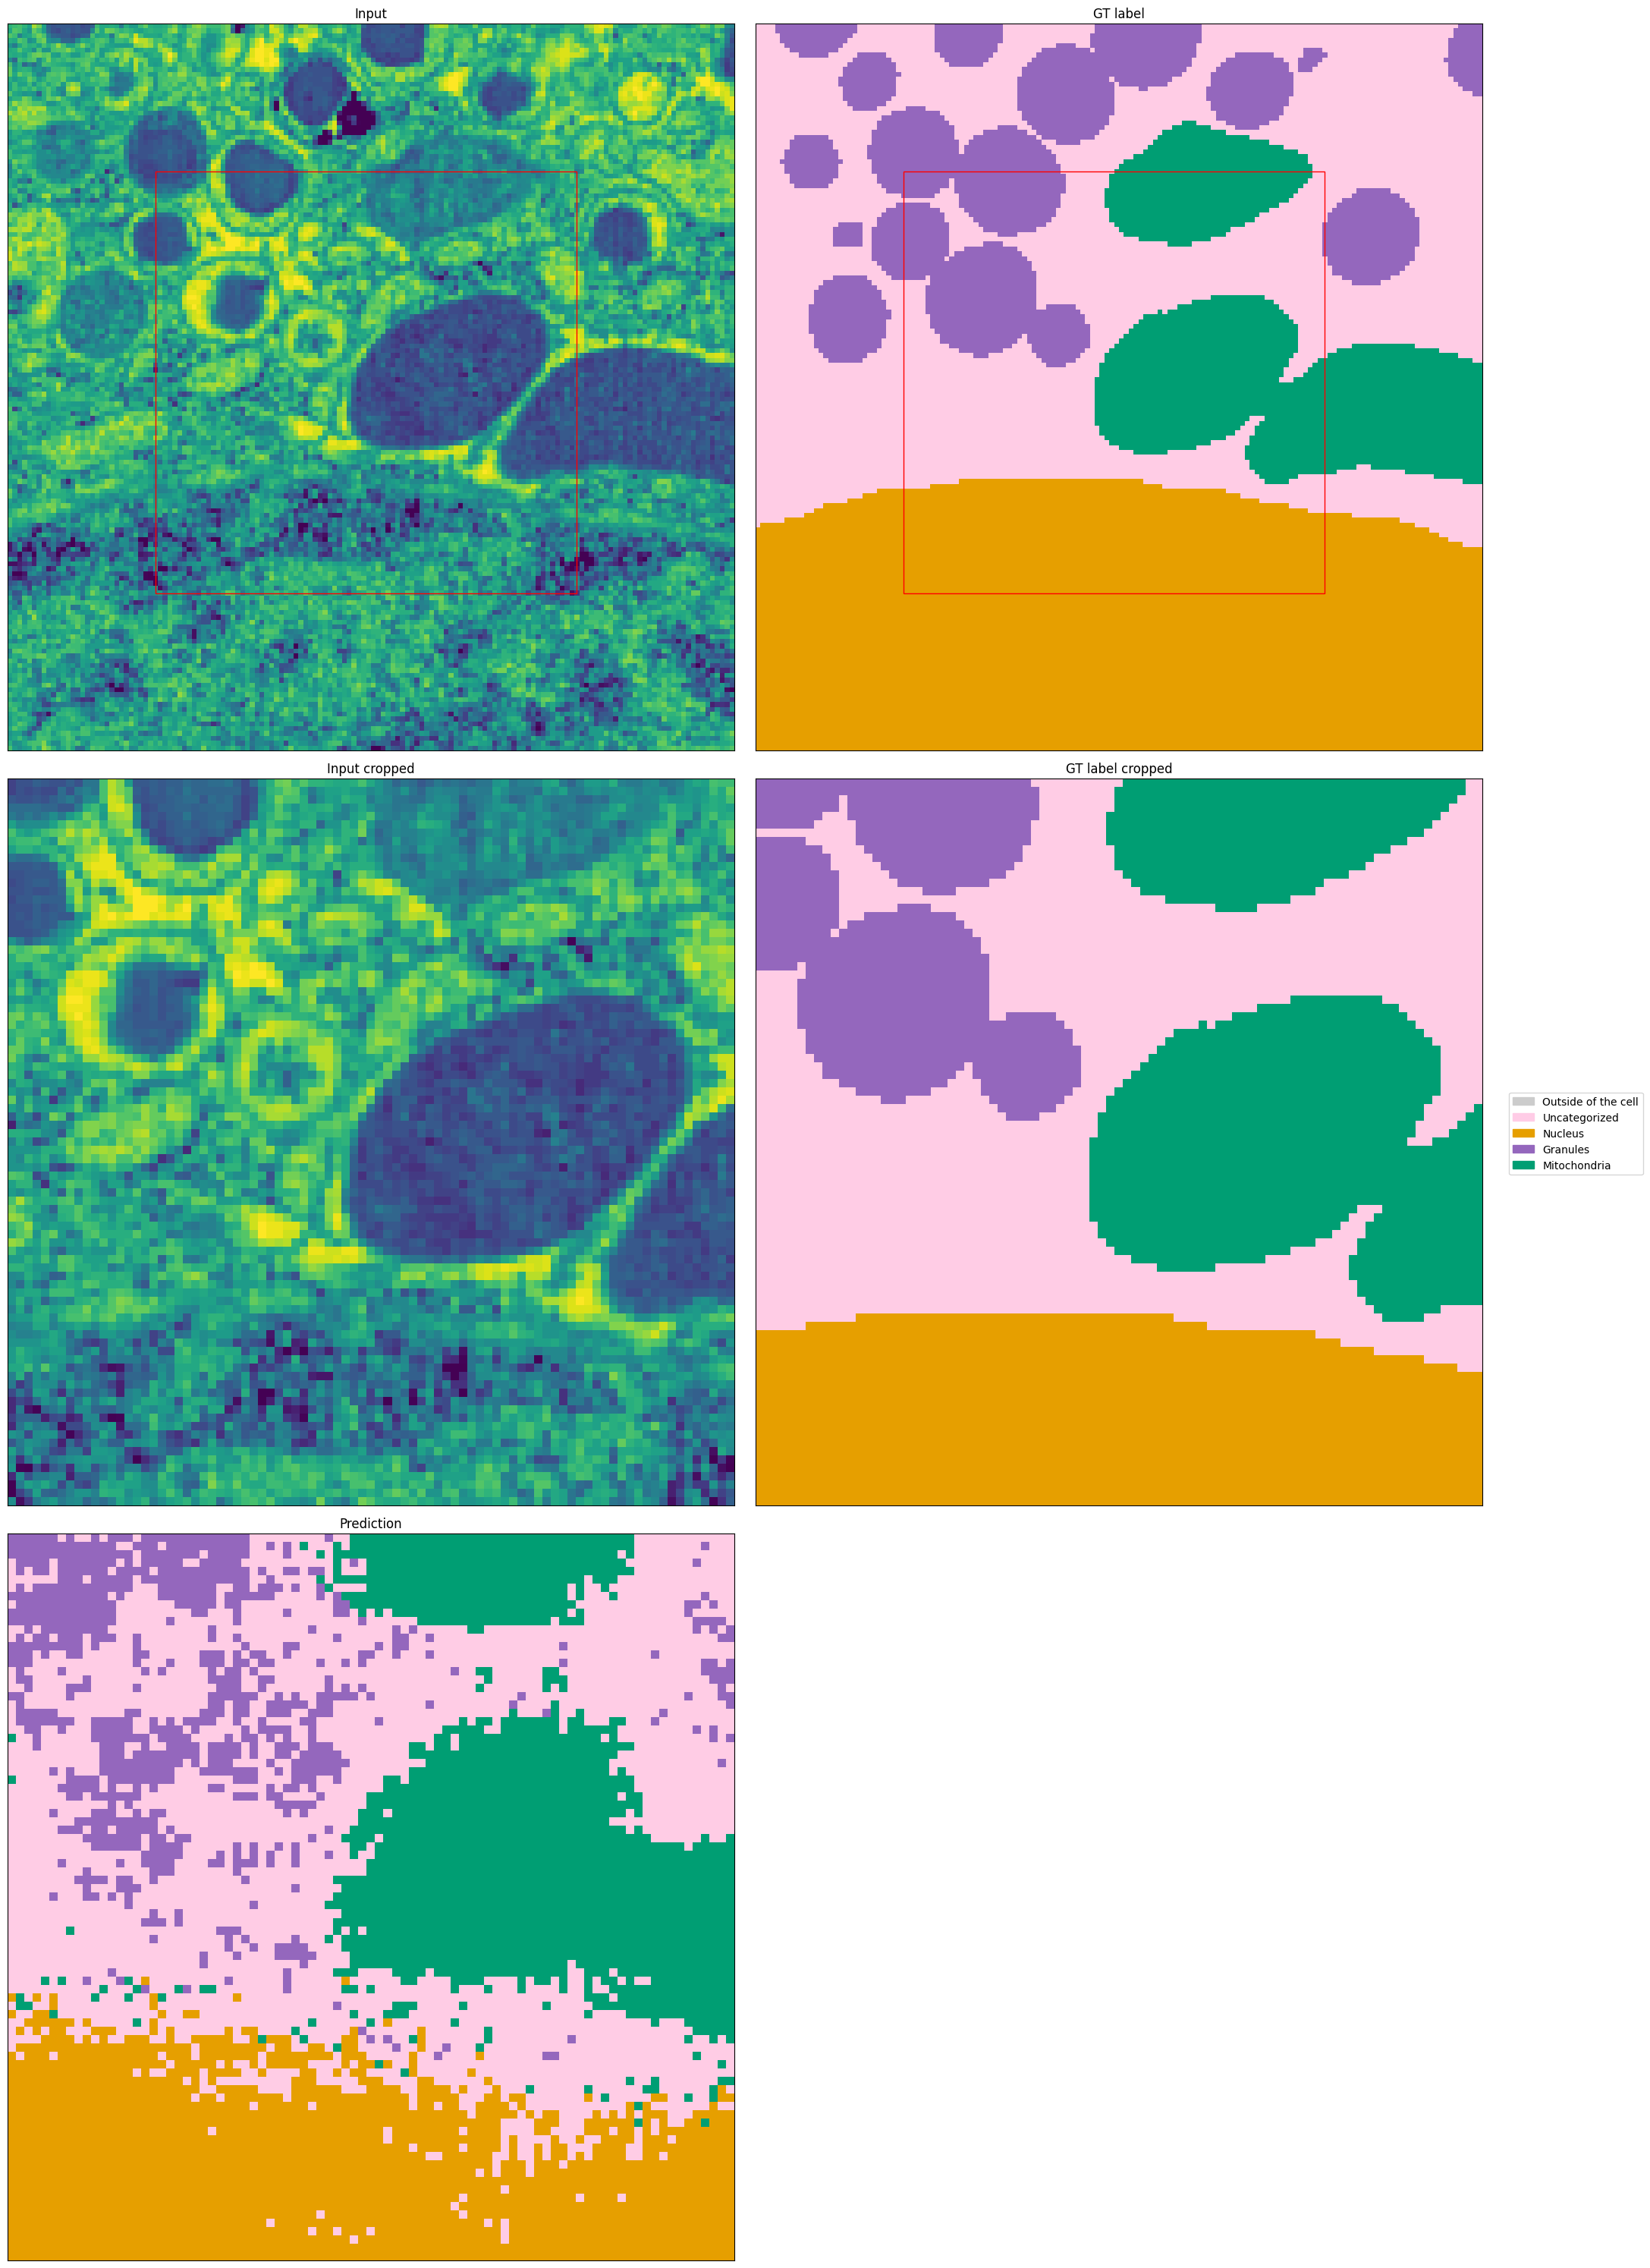

In [41]:
p.plot_w_b( (test_slice[y1:y2, x1:x2], "Input", (pad_size, pad_size, 87)),\
        (test_slice_lbl[y1:y2, x1:x2], "GT label", (pad_size, pad_size, 87)),\
        (test_slice[y1+pad_size:y2-pad_size-3, x1+pad_size:x2-pad_size-3], "Input cropped", False),\
        (test_slice_lbl[y1+pad_size:y2-pad_size-3, x1+pad_size:x2-pad_size-3], "GT label cropped", False),\
        (feature_maps, "Prediction", False),\
        plot_types=['imshow', 'imshow_l', 'imshow', 'imshow_l', 'imshow_l'],
        box_size=10)

In [ ]:
np.unique(feature_maps, return_counts=True)